In [59]:
from numpy import frompyfunc, arange
from scipy.optimize import fminbound
from scipy.special import hyp2f1, gamma, rgamma
from scipy.integrate import quad
from scipy.special import erfinv
import matplotlib.pyplot as plt

In [60]:
def bayes_factor(Non, Noff, alpha):
    """
    Calculate the Bayes factor, representing the odds of background hypothesis over the signal hypothesis.
    """
    Nges = Non + Noff
    gam = (1 + 2 * Noff) * alpha**0.5 * gamma(0.5 + Nges)
    delta = 2 * (1 + alpha)**Nges * gamma(1 + Nges) * hyp2f1(0.5 + Noff, 1 + Nges, 1.5 + Noff, -1 / alpha)
    c1_c2 = 2 * (pi / 4) ** 0.5
    return gam / (c1_c2 * delta)

In [61]:
def signal_posterior(lambda_s, Non, Noff, alpha):
    """
    Calculate the marginalized signal parameter posterior.
    """
    n1 = Non + Noff
    buf1 = lambda_s**n1 * rgamma(n1 + 1) * exp(-lambda_s)
    buf2 = hyp2f1(Noff + 0.5, n1 + 1, Noff + 1.5, -1 / alpha)
    buf3 = rgamma(Noff + 1.5)
    return buf1 * buf2 / buf3

In [62]:
def cumulative_distribution(lambda_s, Non, Noff, alpha):
    """
    Calculate the cumulative distribution function of the signal posterior.
    """
    return quad(lambda x: signal_posterior(x, Non, Noff, alpha), 0, lambda_s)

In [63]:
def bayesian_z_value(Non, Noff, alpha):
    """
    Calculate the Bayesian z-value via the Bayes factor.
    """
    bayes_factor_val = bayes_factor(Non, Noff, alpha)
    buf = 1 - bayes_factor_val
    return (2 ** 0.5) * erfinv(max(min(buf, 1), -1))

In [64]:
def find_local_maximum(Non, Noff, alpha):
    """
    Find the local maximum of the signal posterior.
    """
    sigma = (alpha ** 2 * Noff + Non) ** 0.5
    lstar = Non - alpha * Noff

    if lstar <= 0:
        return 0

    lmin = max(lstar - sigma, 1e-11)
    lmax = lstar + sigma

    res = fminbound(lambda x: -signal_posterior(x, Non, Noff, alpha), lmin, lmax)
    return res

In [67]:
def credible_interval(Non, Noff, alpha, percentile):
    """
    Find the credible interval for a given percentile.
    """
    sigma = (alpha ** 2 * Noff + Non) ** 0.5
    lstar = Non - alpha * Noff

    if percentile == 0.99:
        lmax = lstar + 2 * sigma
    elif percentile == 0.84:
        lmax = lstar + sigma
    elif percentile == 0.16:
        lmax = lstar - sigma
    else:
        raise ValueError("Invalid percentile")

    guess = 3 + lmax if percentile == 0.99 else 1 + lmax
    if percentile == 0.99:
        lower_bound = lstar
        upper_bound = lmax
    else:
        lower_bound = 0
        upper_bound = lmax

    b = fminbound(lambda x: -signal_posterior(x, Non, Noff, alpha), lower_bound, upper_bound, xtol=1e-8)
    return b

Measurement: N_on, N_off, alpha, B_01, S_B_01, signal_estimate
29, 34, 0.200, 1.020e+37, -inf, <33.220


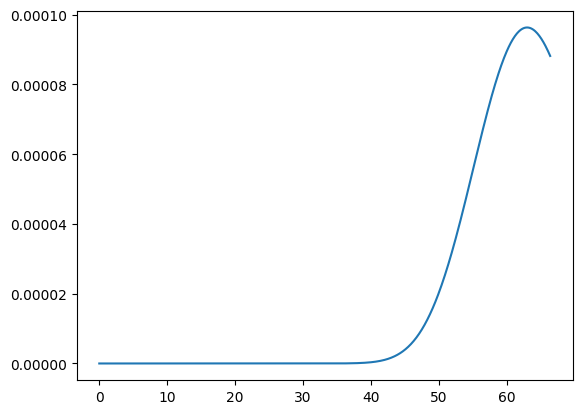

In [70]:
if __name__ == "__main__":
    n_on = 29
    n_off = 34
    alpha = 1 / 5

    l_99_buf = credible_interval(n_on, n_off, alpha, 0.99)
    significance = bayesian_z_value(n_on, n_off, alpha)
    if significance > 3.0:
        l_star_buf = find_local_maximum(n_on, n_off, alpha)
        l_84_buf = credible_interval(n_on, n_off, alpha, 0.84)
        l_16_buf = credible_interval(n_on, n_off, alpha, 0.16)
        print("Measurement: N_on, N_off, alpha, B_01, S_B_01, signal_estimate")
        print(f"{n_on}, {n_off}, {alpha:.3f}, {bayes_factor(n_on, n_off, alpha):.3e}, {significance:.3f}, "
              f"{l_star_buf:.3f} + {l_84_buf - l_star_buf:.3f} - {l_star_buf - l_16_buf:.3f}")
    else:
        print("Measurement: N_on, N_off, alpha, B_01, S_B_01, signal_estimate")
        print(f"{n_on}, {n_off}, {alpha:.3f}, {bayes_factor(n_on, n_off, alpha):.3e}, {significance:.3f}, "
              f"<{l_99_buf:.3f}")

    # Plot the PDF
    x_range = arange(0, 2 * l_99_buf, 0.1)
    y_range = signal_posterior(x_range, n_on, n_off, alpha)
    plt.plot(x_range, y_range)
    plt.show()